In [30]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow

In [31]:
# Baca kunci jawaban dari file CSV
df = pd.read_csv('answer.csv')
ANSWER_KEY = {}
for i in df.values:
    print(i[0], i[1])
    ANSWER_KEY[i[0]] = i[1]

print(ANSWER_KEY)

1 2
2 5
3 1
4 5
5 2
{1: 2, 2: 5, 3: 1, 4: 5, 5: 2}


In [32]:
# Muat gambar dan praproses
image = cv2.imread("omr_test_01.png")
# konversi ke citra skala abu-abu
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#menghaluskan gambar menggunakan filter Gaussian
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#mendeteksi tepi menggunakan algoritma Canny.
edged = cv2.Canny(blurred, 75, 200)

In [34]:
# Temukan kontur dokumen
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

if len(cnts) > 0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            docCnt = approx
            break

In [25]:
# Transformasi perspektif empat titik
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

In [26]:
# Thresholding Otsu
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0

In [27]:
# Proses pengenalan jawaban
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None

    for (j, c) in enumerate(cnts):
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)

        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)

    color = (0, 0, 255)
    k = ANSWER_KEY[q+1]

    if k == bubbled[1]+1:
        color = (0, 255, 0)
        correct += 1

    cv2.drawContours(paper, [cnts[k-1]], -1, color, 3)

[INFO] score: 80.00%


array([[[134, 157, 170],
        [228, 249, 250],
        [217, 239, 243],
        ...,
        [144, 157, 166],
        [152, 162, 169],
        [129, 139, 144]],

       [[121, 143, 153],
        [222, 240, 243],
        [216, 235, 238],
        ...,
        [241, 243, 244],
        [245, 246, 247],
        [237, 240, 239]],

       [[103, 125, 133],
        [206, 225, 231],
        [204, 221, 226],
        ...,
        [247, 249, 248],
        [253, 254, 254],
        [230, 235, 234]],

       ...,

       [[140, 164, 176],
        [174, 201, 213],
        [156, 182, 194],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [198, 196, 196]],

       [[157, 181, 193],
        [191, 219, 231],
        [173, 201, 212],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [230, 226, 229]],

       [[ 90, 110, 123],
        [120, 140, 156],
        [111, 131, 145],
        ...,
        [206, 200, 202],
        [202, 198, 202],
        [179, 176, 181]]], dtype=uint8)
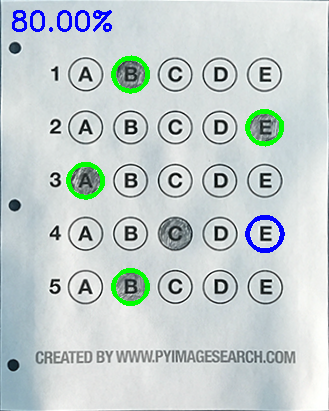

In [28]:
# Hitung skor
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)


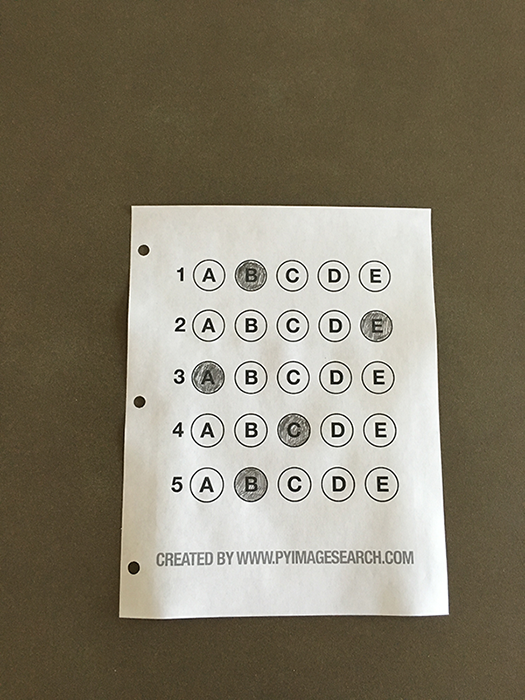

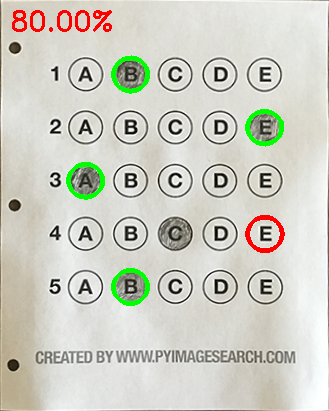

-1

In [29]:
# Tampilkan gambar
cv2_imshow(image)
cv2_imshow(paper)
cv2.waitKey(0)